# PDAN8412 PROGRAMMING POE - ST10065806

I will attempt to use CNN and Keras to classify photos in this notebook.

1. We'll import some helpful packages first.
2. The data will then be loaded before being visualised and processed.
3. We'll test a straightforward CNN model, then assess how it performs.
4. Then, in order to address this difficulty as well, we will employ a pre-trained model.

Dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

This dataset contains images from a collection of global natural scenes, we will be using 10 thousand pictures from this collection in our classification.

Refrences: 

1. https://www.kaggle.com/code/arbazkhan971/image-classification-using-cnn-94-accuracy
2. https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras#Beginner:-Simple-Model-Creation
3. https://www.kaggle.com/code/uzairrj/beg-tut-intel-image-classification-93-76-accur

## Imports

Import pandas, numpy, matplotlib, seaborn, os, cv2, sklearn and tensorflow. Then set %matplotlib inline

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

Creating variables and labels

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

## Loading the data

To load the images and labels from the folder, we must create a load data function.

Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.

In [3]:
def load_data():

    datasets = ['train', 'test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|██████████| 2382/2382 [00:04<00:00, 485.44it/s]


Loading test


100%|██████████| 501/501 [00:01<00:00, 452.16it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## Exploratory Data Analysis

In our exploratory data analysis, we will try to answer these questions:

- How many training and testing examples do we have?
- What is the size of the images?
- What is the proportion of each observed category?

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


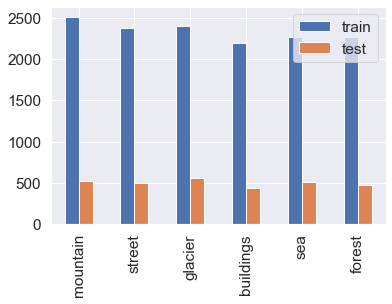

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

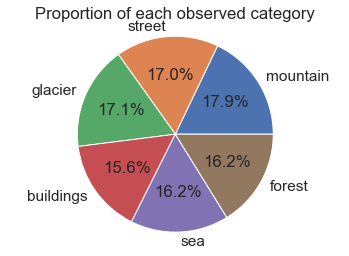

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

It is a good practice to scale the data when using images

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

 Displaying a random image from the images array and its correspond label from the labels array.

In [10]:
def display_random_image(class_names, images, labels):

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

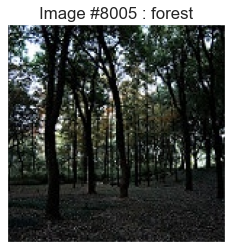

In [11]:
display_random_image(class_names, train_images, train_labels)

 Displaying 25 images from the images array with its corresponding labels

In [12]:
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

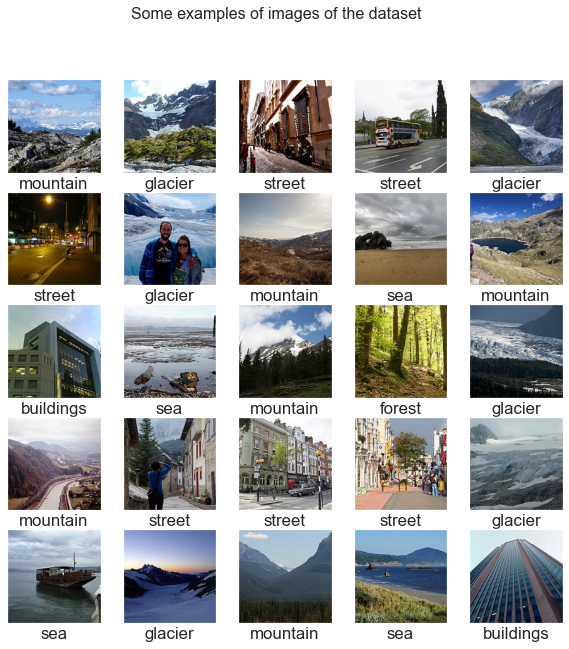

In [13]:
display_examples(class_names, train_images, train_labels)

## Model Creation

Steps are:

1. Create the model,
2. assemble the model,
3. train the model and fit the data to it,
4. the model's performance on the test set,
5. run our model through an error analysis.

We can create a simple model with various layers, such as:

- Conv2D: (32 filters of size 3 by 3) (32 filters of size 3 by 3) From the image, the features will be "extracted."
- Images are halved in size thanks to MaxPooling2D.
- Flattening changes the photos' format from a two-dimensional array to a one-dimensional array with 150 150 3 pixel values.
- Relu: returns the maximum value given x. (x, 0).
- Softmax: 6 neurons, class membership probability for the image.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Plot the accuracy and the loss during the training of the CNN

In [15]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

## Pipeline used for traing the model

Step 1: We can compile the model by using certain parameters

- Adam is optimised as RMSProp plus momentum. What are RMSProp and Momentum?

        Momentum = has a better update by considering previous gradient.

        RMSProp stands for the exponentially weighted average of the gradient squares over time.

- Loss function: We classify using sparse categorical crossentropy, where each image only 

Step 2: We adjusted the model to the training set's data. The pattern needed to discriminate between each category will be learned by the neural network on its own.

Epoch 1/20
88/88 [==============================] - 129s 1s/step - loss: 1.2519 - accuracy: 0.5384 - val_loss: 0.8795 - val_accuracy: 0.6598
Epoch 2/20
88/88 [==============================] - 109s 1s/step - loss: 0.7729 - accuracy: 0.7143 - val_loss: 0.7396 - val_accuracy: 0.7317
Epoch 3/20
88/88 [==============================] - 103s 1s/step - loss: 0.6047 - accuracy: 0.7824 - val_loss: 0.7666 - val_accuracy: 0.7139
Epoch 4/20
88/88 [==============================] - 97s 1s/step - loss: 0.4679 - accuracy: 0.8372 - val_loss: 0.7612 - val_accuracy: 0.7367
Epoch 5/20
88/88 [==============================] - 92s 1s/step - loss: 0.3439 - accuracy: 0.8824 - val_loss: 0.6880 - val_accuracy: 0.7531
Epoch 6/20
88/88 [==============================] - 122s 1s/step - loss: 0.2491 - accuracy: 0.9185 - val_loss: 0.7844 - val_accuracy: 0.7492
Epoch 7/20
88/88 [==============================] - 118s 1s/step - loss: 0.1753 - accuracy: 0.9470 - val_loss: 0.7981 - val_accuracy: 0.7688
Epoch 8/20
88/8

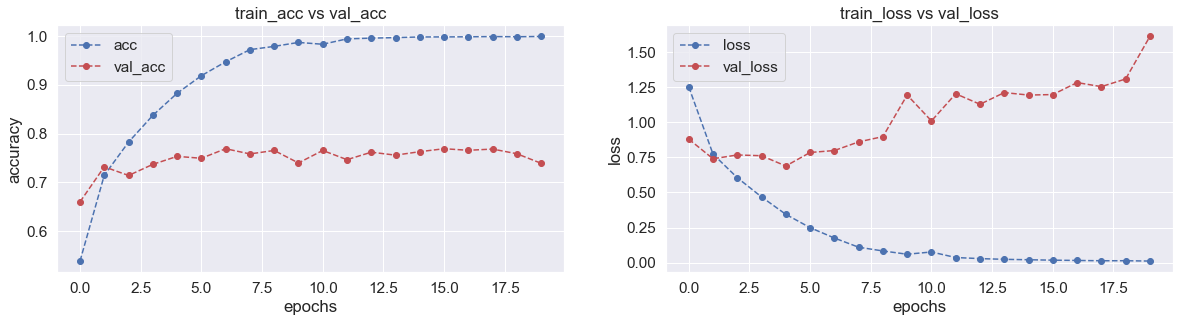

In [16]:
def pipeline():

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)
    plot_accuracy_loss(history)

pipeline()

From this we see that the validation accuracy does not improve after few epochs and the validation loss is increasing after few epochs. 

### Evaluating the model performance on test set

In [17]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 10s 105ms/step - loss: 1.6752 - accuracy: 0.7310


We can see that in the testing test, we had an accuracy of 0.76 . We see that the model was slightly underfit.

#### Classification Report

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Vector of probabilities
predictions = model.predict(test_images)

 # We take the highest probability
pred_labels = np.argmax(predictions, axis = 1)

print(classification_report(test_labels, pred_labels, target_names=class_names))

94/94 [==============================] - 9s 80ms/step
              precision    recall  f1-score   support

    mountain       0.64      0.78      0.70       525
      street       0.70      0.87      0.77       501
     glacier       0.64      0.81      0.71       553
   buildings       0.86      0.47      0.60       437
         sea       0.84      0.52      0.64       510
      forest       0.90      0.92      0.91       474

    accuracy                           0.73      3000
   macro avg       0.76      0.73      0.72      3000
weighted avg       0.76      0.73      0.72      3000



The report is not too bad, however as we can see the model is around 76% accurate. Meaning that 1 in 5 can be predicted inaccuratly, which to some would not be a good enogh accuracy for something like cancer prediciton or health classification but in terms of what we are trying to classify it is good enough. 

Let's see how the classifier performs using some random photos.

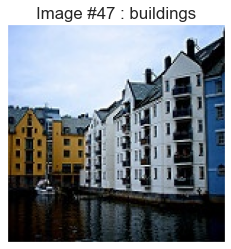

In [19]:
display_random_image(class_names, test_images, pred_labels)

## Confusion Matrix

A table called a confusion matrix is used to describe how well a classification system performs. The output of a classification algorithm is shown and summarised in a confusion matrix. The model's accuracy and correctness are gauged using the confusion matrix.

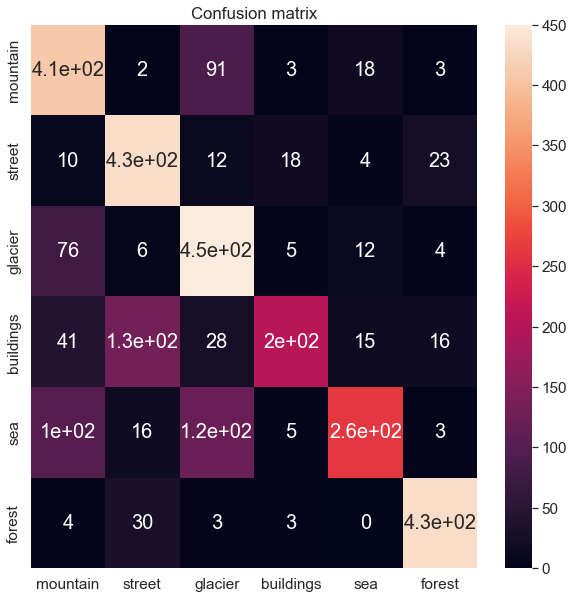

In [20]:
CM = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sn.heatmap(CM, annot=True, 
           annot_kws={"size": 20}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

As seen above the confusion matrix confirms the accuracy of our model.

## Error Analysis

We can try to understand on which kind of images the classifier has trouble.

We will print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels

In [21]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
   
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

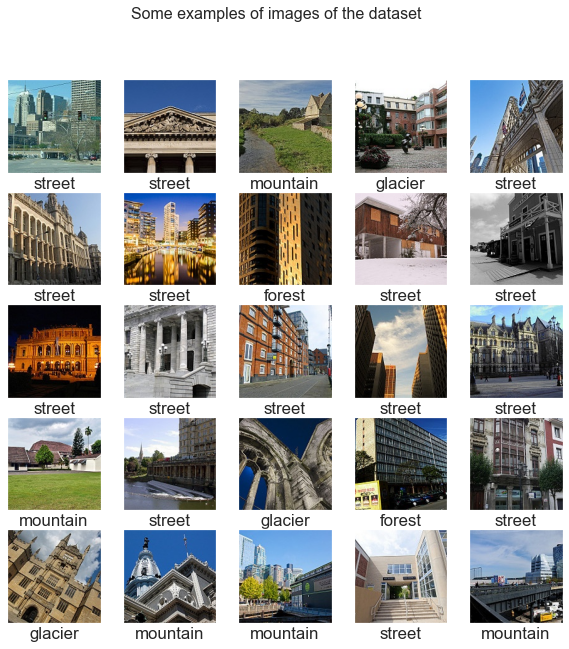

In [22]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

## Conclusion

The classifier has issues with 2 kinds of images being buildings and streets. Well, given that the roadway is lined with buildings, that is somewhat understandable. Additionally, it struggles with the sea, glaciers, and mountains. I find it difficult to adequately discern between them. However, it has a very good sense of forest detection!